# Scanpy Single-Cell RNA-seq testing on CPU of 246 server

## Import requirements

In [1]:
import time

#import numpy as np
#import scanpy as sc

import os, wget

#from sklearn.cluster import KMeans

##
import numpy as np
import pandas as pd
import scanpy as sc
##

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.8.0 umap==0.5.1 numpy==1.21.2 scipy==1.6.0 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.13.0 python-igraph==0.9.9 pynndescent==0.5.6


## Input data & Load Data

In [3]:
%%time
#Input files
adata = sc.read_10x_mtx(
    './data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.rea

... reading from cache file cache/data-matrix.h5ad
CPU times: user 516 ms, sys: 96 ms, total: 612 ms
Wall time: 611 ms


## Preprocessing

In [4]:
%%time
#sc.pl.highest_expr_genes(adata, n_top=20, )

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)

#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

filtered out 36 cells that have less than 200 genes expressed
filtered out 20111 genes that are detected in less than 3 cells
CPU times: user 252 ms, sys: 36 ms, total: 288 ms
Wall time: 286 ms


### Filtering

normalizing counts per cell
    finished (0:00:00)


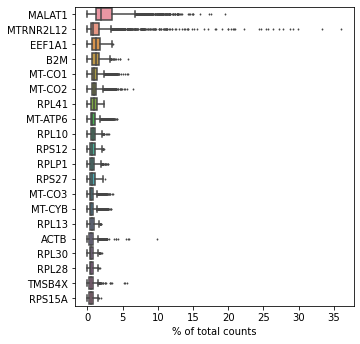

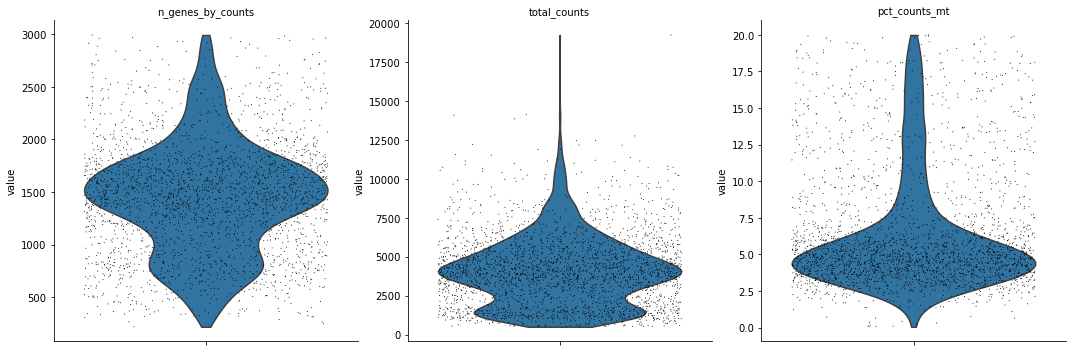

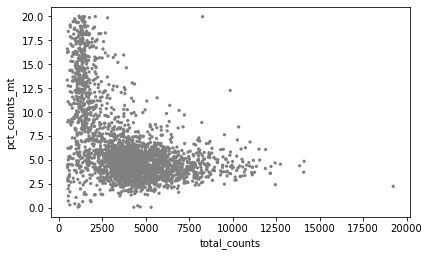

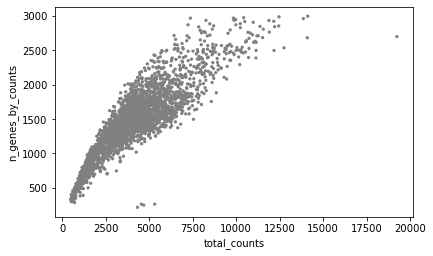

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Normalization & Scaling the data

In [6]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 102 ms


## Select Most Variable Genes

In [7]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 764 ms, sys: 8 ms, total: 772 ms
Wall time: 770 ms


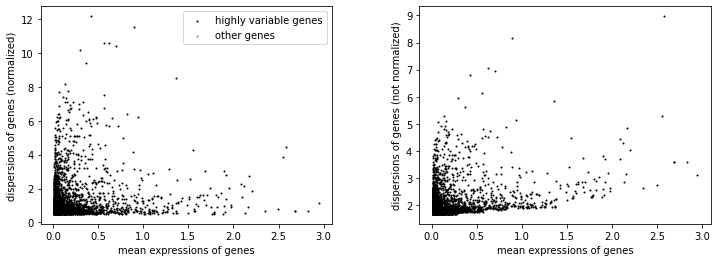

In [8]:
sc.pl.highly_variable_genes(adata)

## Regress out confounding factors (number of counts, mitochondrial gene expression)

In [9]:
%%time
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)
CPU times: user 14.2 s, sys: 96 ms, total: 14.3 s
Wall time: 14.3 s


### Scale data

In [10]:
sc.pp.scale(adata, max_value=10)

## Perform linear dimensional reduction

In [11]:
%%time
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
CPU times: user 11.5 s, sys: 11.9 s, total: 23.4 s
Wall time: 812 ms


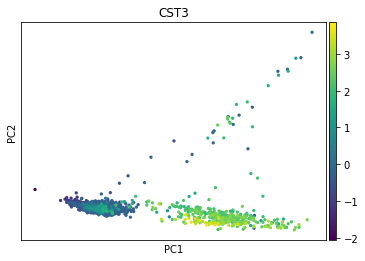

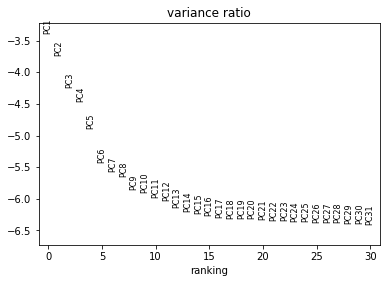

In [12]:
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

## Clustering

In [13]:
%%time
#Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

#Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=0.3)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
CPU times: user 10.4 s, sys: 13.3 s, total: 23.7 s
Wall time: 4.16 s


## Run non-linear dimensional reduction (UMAP)

In [14]:
%%time
#Embedding the neighborhood graph (UMAP)
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
CPU times: user 10.5 s, sys: 12.4 s, total: 22.9 s
Wall time: 6.08 s


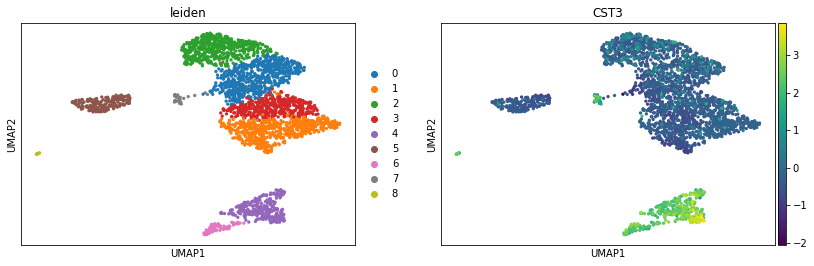

In [15]:
sc.pl.umap(adata, color=['leiden', 'CST3'])

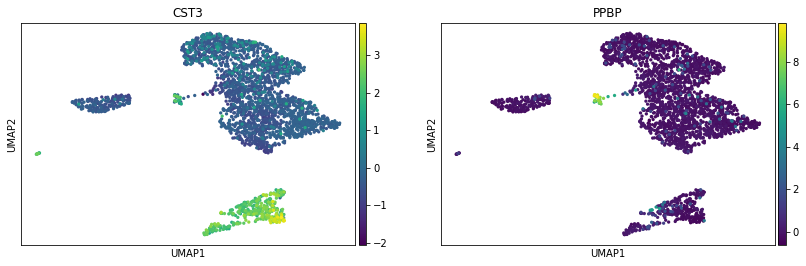

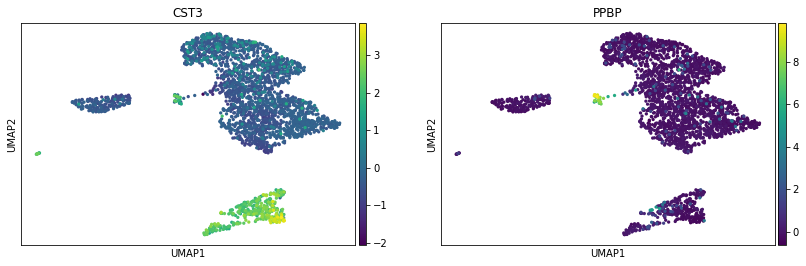

In [16]:
sc.pl.umap(adata, color=['CST3', 'PPBP'])
sc.pl.umap(adata, color=['CST3', 'PPBP'], use_raw=False)

## Finding marker genes & Differential expression analysis

In [17]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


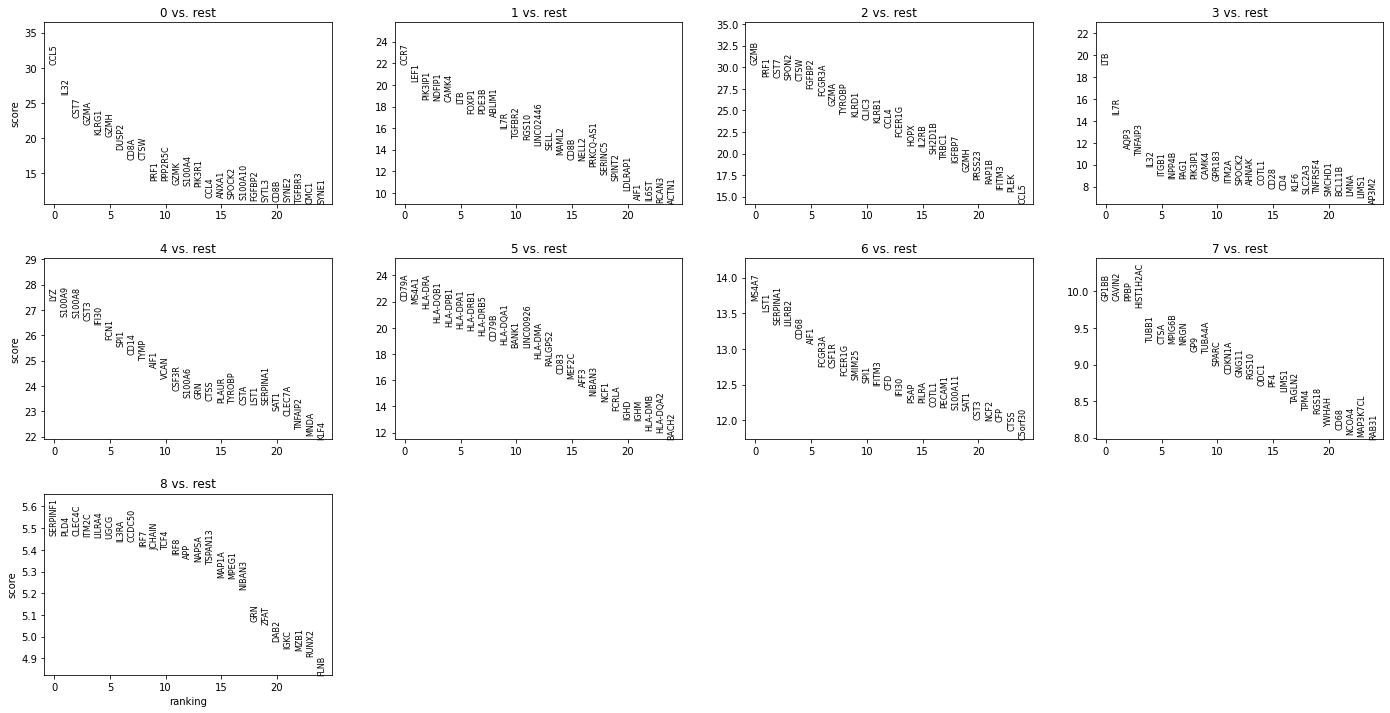

In [18]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [19]:
results_file = './write/CPU_test_AIDA_Pilot_RAPIDs.h5ad'
adata.write(results_file)

In [20]:
marker_genes = ['CD8A', 'CD8B', 'IL7R', 'CCR7', 'CST7', 'KLRB1', 
                'S100A4', 'CD14', 'LYZ', 'LGALS3', 'S100A8', 
                'MS4A1','CD79A', #, 'GNLY', 'NKG7'
                'FCGR3A', 'MS4A7', 'PPBP', 'FCER1A', 'CST3']

In [21]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,CCL5,CCR7,GZMB,LTB,LYZ,CD79A,MS4A7,GP1BB,SERPINF1
1,IL32,LEF1,PRF1,IL7R,S100A9,MS4A1,LST1,CAVIN2,PLD4
2,CST7,PIK3IP1,CST7,AQP3,S100A8,HLA-DRA,SERPINA1,PPBP,CLEC4C
3,GZMA,NDFIP1,SPON2,TNFAIP3,CST3,HLA-DQB1,LILRB2,HIST1H2AC,ITM2C
4,KLRG1,CAMK4,CTSW,IL32,IFI30,HLA-DPB1,CD68,TUBB1,LILRA4


In [22]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,CCL5,1.469240e-204,CCR7,2.214097e-106,GZMB,3.466822e-202,LTB,8.413982e-82,LYZ,2.598304e-165,CD79A,1.496643e-108,MS4A7,1.187670e-42,GP1BB,4.873773e-23,SERPINF1,4.594345e-08
1,IL32,1.275558e-152,LEF1,4.777096e-92,PRF1,8.422629e-185,IL7R,3.399300e-48,S100A9,1.380225e-157,MS4A1,2.616096e-106,LST1,1.094326e-41,CAVIN2,4.916607e-23,PLD4,4.594345e-08
2,CST7,5.633668e-117,PIK3IP1,1.680799e-77,CST7,2.479489e-182,AQP3,1.854357e-30,S100A8,2.180987e-157,HLA-DRA,2.577620e-102,SERPINA1,1.186740e-40,PPBP,5.238495e-23,CLEC4C,4.594345e-08
3,GZMA,2.330820e-107,NDFIP1,6.344424e-77,SPON2,1.212170e-179,TNFAIP3,2.611068e-27,CST3,1.021683e-155,HLA-DQB1,8.573485e-93,LILRB2,1.436523e-40,HIST1H2AC,1.358499e-22,ITM2C,4.750912e-08
4,KLRG1,1.800259e-93,CAMK4,5.839535e-76,CTSW,3.431975e-178,IL32,4.594695e-23,IFI30,4.206114e-154,HLA-DPB1,9.686827e-90,CD68,1.582478e-39,TUBB1,1.415715e-20,LILRA4,4.793529e-08


In [23]:
#%%time
#sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')

In [24]:
#%%time
#sc.pl.rank_genes_groups(adata, n_genes=20)

In [25]:
%%time
sc.tl.rank_genes_groups(adata, groupby="leiden", n_genes=20, groups='all', reference='rest', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
CPU times: user 2.33 s, sys: 144 ms, total: 2.47 s
Wall time: 2.47 s


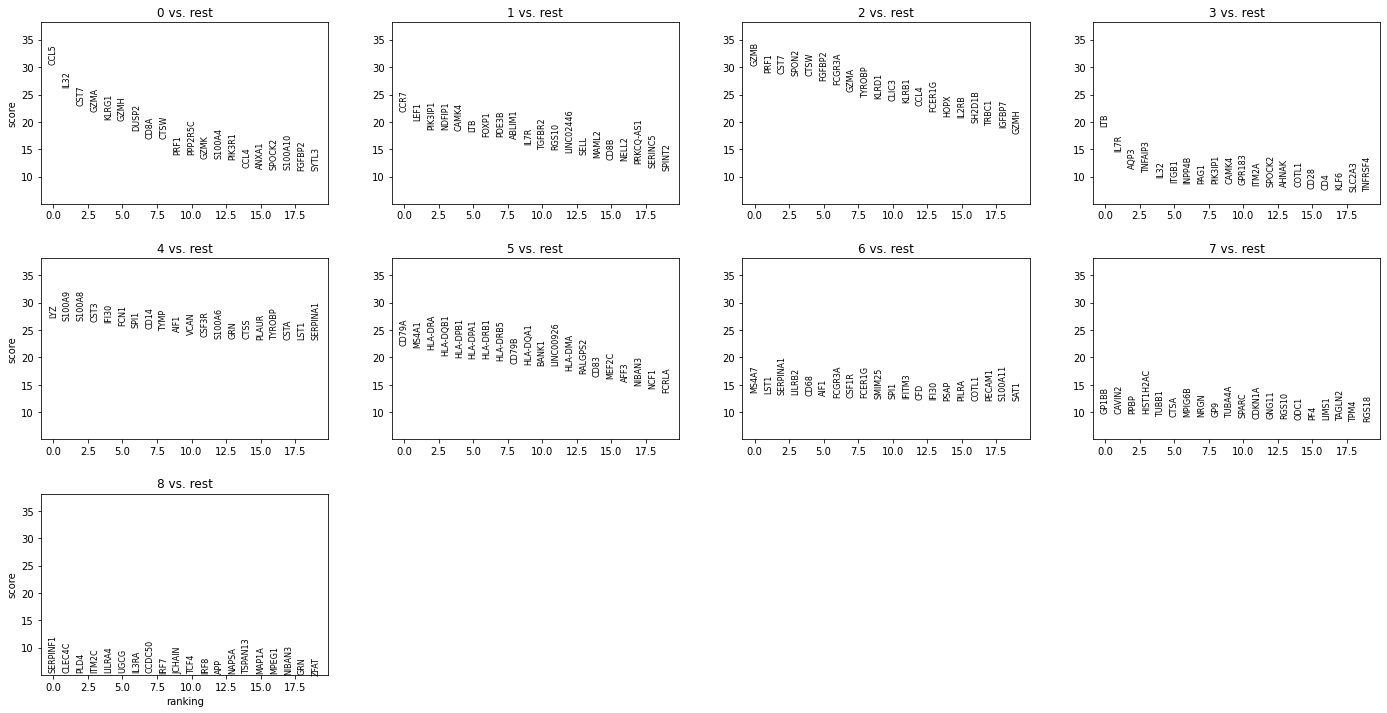

CPU times: user 2.09 s, sys: 188 ms, total: 2.28 s
Wall time: 2.02 s


In [26]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

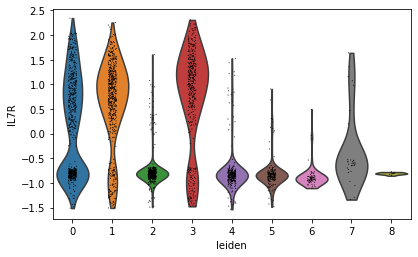

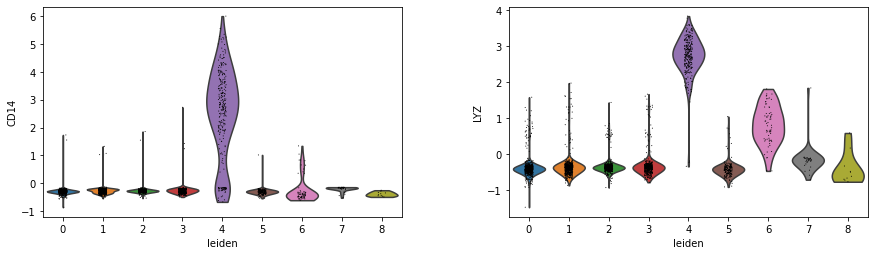

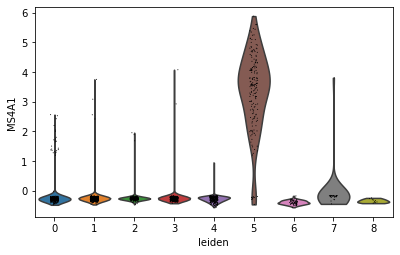

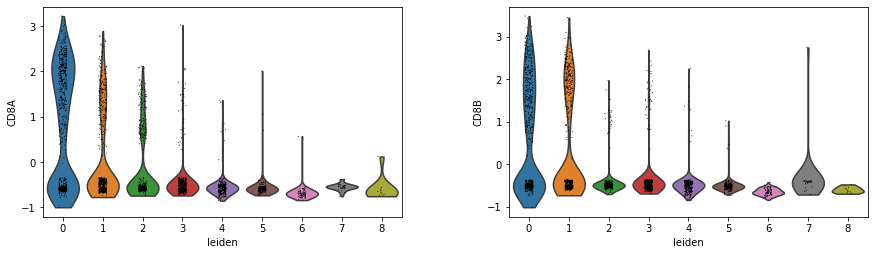

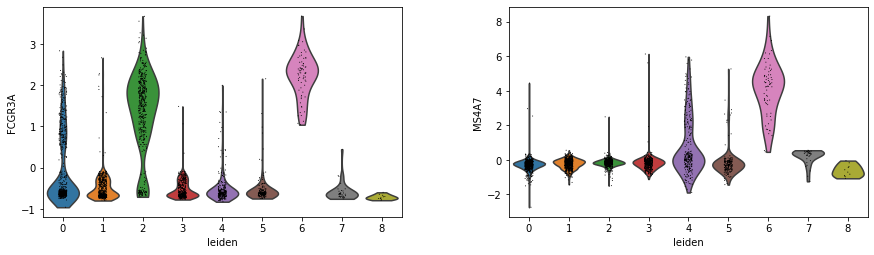

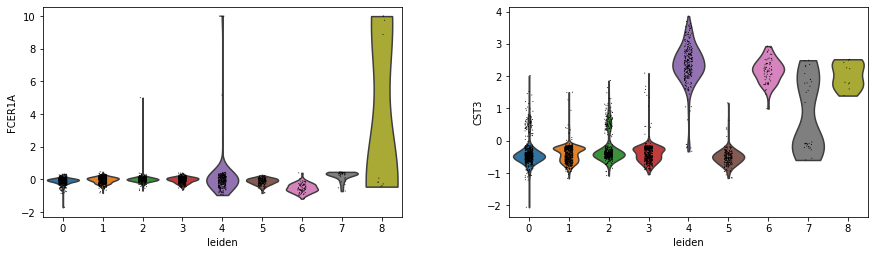

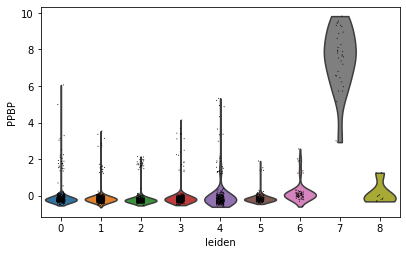

In [27]:
#CD4 T cells
sc.pl.violin(adata, ['IL7R'], groupby='leiden')
#CD14+ Monocytes
sc.pl.violin(adata, ['CD14', 'LYZ'], groupby='leiden')
#B cells
sc.pl.violin(adata, ['MS4A1'], groupby='leiden')
#CD8 T cells
sc.pl.violin(adata, ['CD8A', 'CD8B'], groupby='leiden')
#NK cells
#sc.pl.violin(adata, ['GNLY', 'NKG7'], groupby='leiden')
#FCGR3A+ Monocytes
sc.pl.violin(adata, ['FCGR3A', 'MS4A7'], groupby='leiden')
#Dendritic Cells
sc.pl.violin(adata, ['FCER1A', 'CST3'], groupby='leiden')
#Megakaryocytes
sc.pl.violin(adata, ['PPBP'], groupby='leiden')

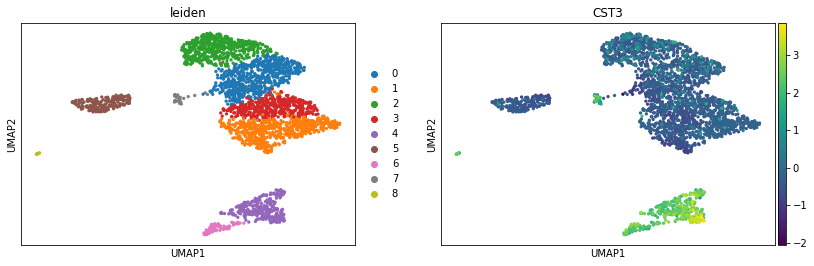

In [28]:
sc.pl.umap(adata, color=['leiden', 'CST3'])

## Cell type identification

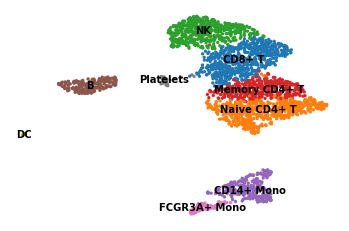

CPU times: user 848 ms, sys: 196 ms, total: 1.04 s
Wall time: 795 ms


In [29]:
%%time
#Cell type identification
new_cluster_names = [
    'CD8+ T', 'Naive CD4+ T',
    'NK', 'Memory CD4+ T',
    'CD14+ Mono', 'B',
    'FCGR3A+ Mono', 'Platelets',
    'DC']
#adata.rename_categories('leiden', new_cluster_names)
adata.obs['leiden'] =adata.obs['leiden'].cat.rename_categories(new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

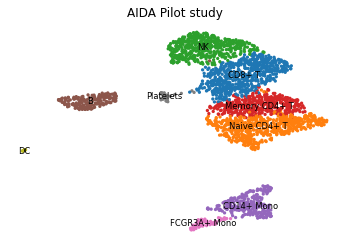

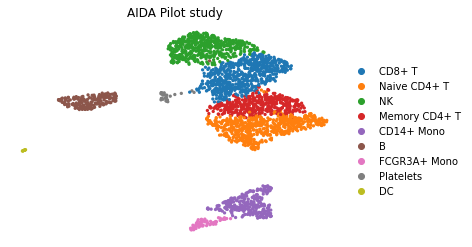

In [30]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontweight='medium', legend_fontsize='small', title='AIDA Pilot study', frameon=False, save='.pdf')
sc.pl.umap(adata, color='leiden', legend_loc='right margin', title='AIDA Pilot study', frameon=False, save='.pdf')

## Visualization (dot plot & violin plot)

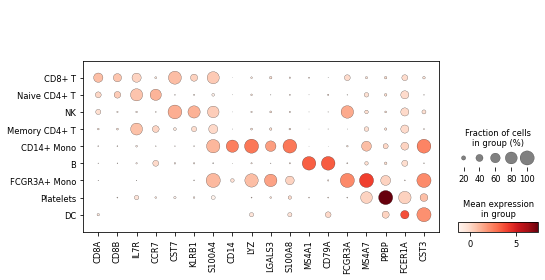

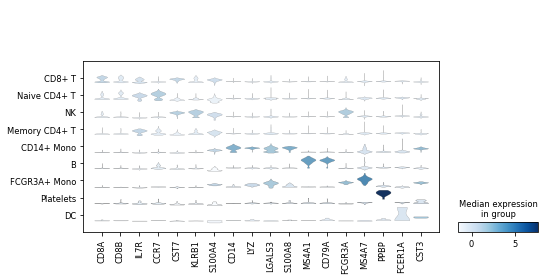

CPU times: user 2.06 s, sys: 344 ms, total: 2.41 s
Wall time: 1.91 s


In [31]:
%%time
#Visualization
#Dot plot
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
#Violin plot
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

## Save file

In [32]:
%%time
#Save file
adata.write(results_file)

CPU times: user 248 ms, sys: 32 ms, total: 280 ms
Wall time: 275 ms
